In [351]:
#download modis satelite image by date 
#python3.9 ./download_modis.py
from pyhdf.SD import SD, SDC
import numpy as np
import matplotlib.pyplot as plt
from ipynb.fs.full.utils import *
from glob import glob
import os
import requests
from urllib.parse import urlparse
from bs4 import BeautifulSoup
import re
import csv
import h5py
import numpy as np
import pywt
diameter = 5

#https://e4ftl01.cr.usgs.gov/MOLT/MOD09CMG.006/


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.0097 0.012  0.0315]


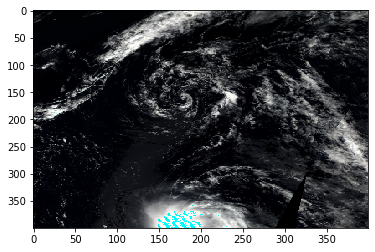

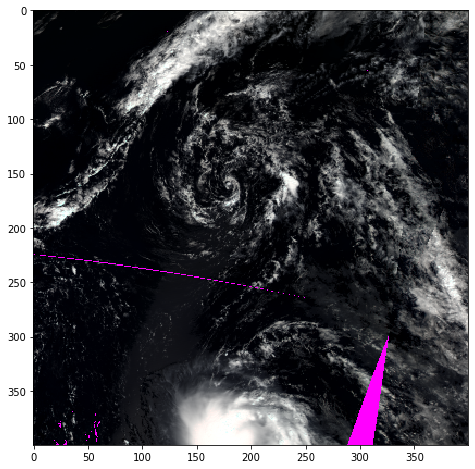

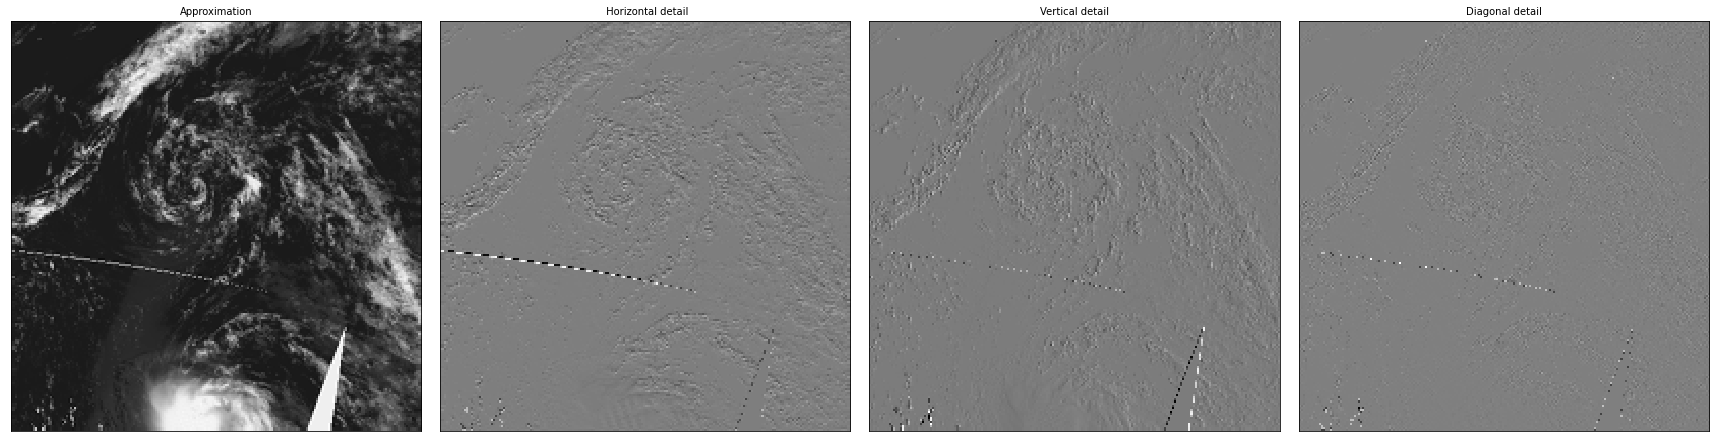

In [399]:

file = '/home/fun/data/AL132005/10_modis_satellite_20050903.npy'
    
rgb = np.load(file)



plt.imshow(rgb, interpolation='nearest', aspect='auto')
#plt.imshow(T20)

#plt.show()

rgb.shape

red = rgb[:, :, 0]
red[red == -2.8672] = 1
blue = rgb[:, :, 2]


green[green  == -2.8672] = 1
blue[blue  == -2.8672] = 1
green = rgb[:, :, 1]



print (rgb[300,180])

rgb_new = np.dstack([red, green, blue])

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(rgb_new, interpolation='nearest')
plt.show()



R_coeffs2 = pywt.dwt2(red, 'bior1.3')
G_coeffs2 = pywt.dwt2(green, 'bior1.3')
B_coeffs2 = pywt.dwt2(blue, 'bior1.3')

titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']

R_LL, (R_LH, R_HL, R_HH) = R_coeffs2
G_LL, (G_LH, G_HL, G_HH) = G_coeffs2
B_LL, (B_LH, B_HL, B_HH) = B_coeffs2

fig = plt.figure(figsize=(24, 6))
for i, a in enumerate([R_LL, R_LH, R_HL, R_HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()


In [84]:
import tensorflow
import keras
from keras import layers

# This is the size of our encoded representations
encoding_dim = 40000  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(40000,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(200, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

In [85]:
encoder = keras.Model(input_img, encoded)

encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [87]:
red = red.astype("float32")

In [88]:
autoencoder.compile(optimizer="adam"
                    , loss='binary_crossentropy')

autoencoder.fit(red, red,
                epochs=50,
                validation_data=(rgb, rgb))

Epoch 1/50


ValueError: in user code:

    /usr/local/lib/python3.6/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.6/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib64/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib64/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib64/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.6/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /usr/local/lib/python3.6/site-packages/keras/engine/training.py:787 train_step
        y_pred = self(x, training=True)
    /usr/local/lib/python3.6/site-packages/keras/engine/base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /usr/local/lib/python3.6/site-packages/keras/engine/functional.py:415 call
        inputs, training=training, mask=mask)
    /usr/local/lib/python3.6/site-packages/keras/engine/functional.py:550 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /usr/local/lib/python3.6/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /usr/local/lib/python3.6/site-packages/keras/engine/input_spec.py:254 assert_input_compatibility
        ' but received input with shape ' + display_shape(x.shape))

    ValueError: Input 0 of layer dense_20 is incompatible with the layer: expected axis -1 of input shape to have value 40000 but received input with shape (32, 1)


In [360]:
def download_file(folder, url, filename):
     
    username_file = open("/home/fun/profile/modis_username.txt", "r")
    password_file = open("/home/fun/profile/modis_password.txt", "r")
    username = username_file.readline()
    password = password_file.readline()
    
    url = url + filename
    if len(filename) == 0:
        filename = 'modis_index.html'
    
    print ('downloading file ', url)
    
    r = requests.get(url, auth = (username, password))
    if r.status_code == 200:
        print ('writing to', folder + filename)
        with open(folder + filename, 'wb') as out:
            for bits in r.iter_content():
                out.write(bits)
    else:
        print ('download error ', r.status_code)
        
def parse_html(html_file):
    '''
    parse html to get file list
    '''       
    with open(html_file, 'r') as input:
        soup = BeautifulSoup(input, "html.parser").find_all(lambda t: t.name == "a" and t.text.startswith('MOD') and t.text.endswith('hdf'))
        filelist = []
        for it in soup:
            filelist.append(it["href"])
        return filelist
    
def generate_modis_url(datestr):
    '''
    compose url using date  'YYYY.MM.DD'
    '''
    url = 'https://e4ftl01.cr.usgs.gov/MOLT/MOD09CMG.006/'+ datestr[0:4] + '.' + datestr[4:6] + '.'+ datestr[6:8] + '/'
    
    return url
    

In [361]:

folder = '/home/fun/data/AL182012/'
url = generate_modis_url('20121024')
print (url)
download_file(folder, url, "")

filelist = parse_html(folder + 'modis_index.html')

if len(filelist) > 0:
    print ('downloading ', filelist[0], 'to ', folder)
    download_file(folder, url, filelist[0])


https://e4ftl01.cr.usgs.gov/MOLT/MOD09CMG.006/2012.10.24/
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD09CMG.006/2012.10.24/
writing to /home/fun/data/AL182012/modis_index.html
downloading  MOD09CMG.A2012298.006.2015250045544.hdf to  /home/fun/data/AL182012/
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD09CMG.006/2012.10.24/MOD09CMG.A2012298.006.2015250045544.hdf
writing to /home/fun/data/AL182012/MOD09CMG.A2012298.006.2015250045544.hdf


KeyboardInterrupt: 

In [225]:
hdf = SD('/home/fun/data/AL182012/MOD09CMG.A2012298.006.2015250045544.hdf')

In [340]:
def getTimeIndex(lon, lat):
    n = 3600
    m = 7200

    interval = 180.0 / n

    lat_index = int((90 - lat) / interval)
    long_index = int((lon + 180) / interval)
    
    return long_index, lat_index

def getTgtArea(global_map, lon, lat, radius):
    n = 3600
    m = 7200

    interval = 180.0 / n

    lat_index = int((90 - lat) / interval)
    long_index = int((lon + 180) / interval)

    n_radius = int(radius / interval)

    return global_map[lat_index - n_radius:lat_index + n_radius, long_index - n_radius:long_index + n_radius]

#def interpolateLocation(day, path, time_array):

In [226]:
for it in hdf.datasets():
    print (it)

time = hdf.select('Coarse Resolution Granule Time').get()

R = hdf.select('Coarse Resolution Surface Reflectance Band 1').get()
B = hdf.select('Coarse Resolution Surface Reflectance Band 3').get()
G = hdf.select('Coarse Resolution Surface Reflectance Band 4').get()

R_true = R * 0.0001
G_true = G * 0.0001
B_true = B * 0.0001

rgb = np.dstack([R_true, G_true, B_true])

Coarse Resolution Surface Reflectance Band 1
Coarse Resolution Surface Reflectance Band 2
Coarse Resolution Surface Reflectance Band 3
Coarse Resolution Surface Reflectance Band 4
Coarse Resolution Surface Reflectance Band 5
Coarse Resolution Surface Reflectance Band 6
Coarse Resolution Surface Reflectance Band 7
Coarse Resolution Solar Zenith Angle
Coarse Resolution View Zenith Angle
Coarse Resolution Relative Azimuth Angle
Coarse Resolution Ozone
Coarse Resolution Brightness Temperature Band 20
Coarse Resolution Brightness Temperature Band 21
Coarse Resolution Brightness Temperature Band 31
Coarse Resolution Brightness Temperature Band 32
Coarse Resolution Granule Time
Coarse Resolution Band 3 Path Radiance
Coarse Resolution QA
Coarse Resolution Internal CM
Coarse Resolution State QA
Coarse Resolution Number Mapping
number of 500m pixels averaged b3-7
number of 500m rej. detector
number of 250m pixels averaged b1-2
n pixels averaged


In [246]:
name = '/home/fun/data/AL182012' + '/profile.json'
f = open(name)
profile = json.load(f)
paths = profile['path']

select_path = paths[9]

print(select_path)

lat = str(select_path['lt'])
lon = str(select_path['lg'])
lom = -1 if lon[-1] == 'W' else 1

lat = float(lat[:-1])
lon = float(lon[:-1])

print(lat, lon)

lon_index, lat_index, = getTimeIndex(lon, lat)

print(lon_index, lat_index)

{'date': 20121024, 'time': '0000', 'category': 'TS', 'lt': '14.7N', 'lg': '77.3W', 'maxwind': '55', 'maxpres': '990', '34ktne': '100', '34ktse': '150', '34ktsw': '150', '34ktnw': '40', '50ktne': '40', '50ktse': '0', '50ktsw': '70', '50ktnw': '0', '64ktne': '0', '64ktse': '0', '64ktsw': '0', '64ktnw': '0', 'maxwindradius': '0'}
14.7 77.3
1505 5146


In [244]:
selected_time = (time[lon_index, lat_index])/60
selected_time # hours after 00:00, 12 AM

7.583333333333333

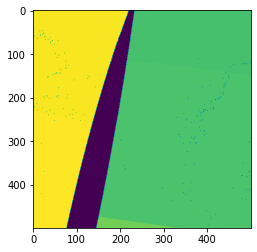

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


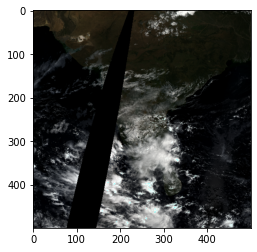

7.583333333333333


array([[630, 630, 630, ..., 450, 450, 450],
       [630, 630, 630, ..., 450, 450, 450],
       [630, 630, 630, ..., 450, 450, 450],
       ...,
       [635, 635, 635, ..., 455, 455, 455],
       [635, 635, 635, ..., 455, 455, 455],
       [635, 635, 635, ..., 455, 455, 455]], dtype=int16)

In [343]:
time_array = getTgtArea(time, lon, lat, 12.5)
selected_rgb = getTgtArea(rgb, lon, lat, 12.5)
plt.imshow(time_array)
plt.show()
plt.imshow(selected_rgb)
plt.show()

# swath gaps come from missing satellite coverage, resulting in non-smooth time differences

print(selected_time)
time_array

In [317]:
def getNearestIndex(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx

def getScaleFactor(small_time, large_time, target_time): # coefficient of multiplication for lin interpolation
    delta_time = large_time - small_time
    delta_target = target_time - small_time
    scale_factor = delta_target/delta_time
    return scale_factor

def coordSTRtoFLOAT(coords): # called in linearInterpolation, shape (2,), lat first then lon
    lat = str(coords[0])
    lon = str(coords[1])
    lom = -1 if lon[-1] == 'W' else 1

    lat = float(lat[:-1])
    lon = float(lon[:-1])
    lon = lon * lom
    
    return lat, lon


def linearCalculation(scale_factor, small_coords, large_coords): # coords passed as shape (2,)

    sm_lat, sm_lon = coordSTRtoFLOAT(small_coords)
    lg_lat, lg_lon = coordSTRtoFLOAT(large_coords)
    
    delta_lat = lg_lat - sm_lat
    delta_lon = lg_lon - sm_lon
    
    scale_lat = delta_lat * scale_factor
    scale_lon = delta_lon * scale_factor
    
    interp_lat = scale_lat + sm_lat
    interp_lon = scale_lon + sm_lon
    
    return interp_lat, interp_lon

def wrappedLinearInterpolation(paths, day, selected_time):
    early_times = []
    early_coords = []
    late_times = []
    late_coords = []
    for path in paths:

        if path['date'] == int(day):
            path_time_hour = float(path['time'])/60
            if path_time_hour <= selected_time:
                early_times = np.append(early_times, path_time_hour)
                early_coords = np.append(early_coords, (path['lt'], path['lg']))
                early_coords = early_coords.reshape(int(len(early_coords)/2), 2)
            else:
                late_times = np.append(late_times, path_time_hour)
                late_coords = np.append(late_coords, (path['lt'], path['lg']))
                late_coords = late_coords.reshape(int(len(late_coords)/2), 2)

    early_index = getNearestIndex(early_times, selected_time)
    late_index = getNearestIndex(late_times, selected_time)

    scale_factor = getScaleFactor(early_times[early_index], late_times[late_index], selected_time)

    new_lon, new_lat = linearCalculation(scale_factor, early_coords[early_index], late_coords[late_index])

    return new_lon, new_lat

def getClosestPath(profile, time_array, day):
    paths = profile['path']
    paths_in_day = []
    time_diffs = []
    for path in paths:
        if path['date'] == int(day):
            paths_in_day = np.append(paths_in_day, path)
    
    for path in paths_in_day:
        # get lt, lg, pass through getTimeIndex(lon, lat)
        # get time[new_lat, new_lon], append to time_diffs
        # time_diffs = time_diffs/60
        # idx = getNearestIndex(time_diffs, early_time)
        # if time_diffs[idx] - early_time >= (late_time - early_time)/2:
            # ...
        # 
    getNearestIndex(array, value)
        

In [407]:
paths_in_day = []
for path in paths:
    if path['date'] == int(20121024):
        day = np.append(day, path)
        
        
day[1]

{'date': 20121024,
 'time': '0600',
 'category': 'TS',
 'lt': '15.6N',
 'lg': '77.1W',
 'maxwind': '60',
 'maxpres': '987',
 '34ktne': '100',
 '34ktse': '150',
 '34ktsw': '150',
 '34ktnw': '50',
 '50ktne': '50',
 '50ktse': '50',
 '50ktsw': '70',
 '50ktnw': '20',
 '64ktne': '20',
 '64ktse': '0',
 '64ktsw': '0',
 '64ktnw': '0',
 'maxwindradius': '0'}

15.3825 -77.14833333333333


ValueError: zero-size array to reduction operation minimum which has no identity

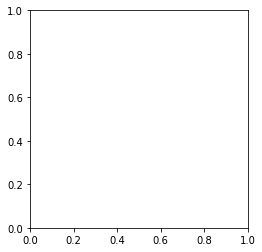

In [401]:
new_lon, new_lat = wrappedLinearInterpolation(paths, '20121024', selected_time)

print(new_lon, new_lat)

new_rgb = getTgtArea(rgb, new_lon, new_lat, 12.5)

plt.imshow(new_rgb)

In [341]:
interp_indices = getTimeIndex(interpolated[1], interpolated[0])
print(interp_indices)
new_time = time[interp_indices[0], interp_indices[1]]
print(new_time/60)

(2057, 1492)
0.0
